In [30]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import torch
import torch.nn as nn
import model as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#cute cat
img = cv2.imread("cat106.jpg")
cv2.imshow("hello", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [57]:
model = m.load_torch_hub("resnet18", True)

Using cache found in C:\Users\netis/.cache\torch\hub\pytorch_vision_v0.10.0


In [58]:
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [59]:
isinstance(model.conv1, nn.Conv2d)

True

In [100]:
model.conv1.weight.shape

torch.Size([64, 3, 7, 7])

In [86]:
def get_convs(model):
    conv_list = []
    children_layers = model.children()
    for layer in children_layers:
        if isinstance(layer, nn.Conv2d):
            conv_list.append(layer)
        elif len(list(layer.children())) > 0:
            conv_list.append(get_convs(layer))
    return flatten_list(conv_list)

def is_list_in_list(lst):
    return sum([isinstance(element, list) for element in lst]) > 0

def flatten_list(lst):
    flat_list = []
    for element in lst:
        flat_element = []
        if isinstance(element, list):
            flat_element = flatten_list(element)
            flat_list += flat_element
        else:
            flat_list.append(element)
    return flat_list

convs = get_convs(model)

In [109]:
import matplotlib.pyplot as plt

def plot_filters_single_channel(conv_layer, interest_dim=None, interest_channel=None, num_cols = 12):
    count = 0
    
    conv_tensor = conv_layer.weight
    channel_dim, num_channel, kernel_width, kernel_height = conv_tensor.shape
    conv_array = conv_tensor.detach().numpy()

    if interest_dim is None:
        interest_dim = range(channel_dim)

    if interest_channel is None:
        interest_channel = range(num_channel)

    num_plots = len(interest_dim) * len(interest_channel)
    num_rows = 1 + num_plots//num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))

    for i in interest_dim:
        for j in interest_channel:
            count += 1
            ax1 = fig.add_subplot(num_rows, num_cols, count)
            img = conv_array[i,j].astype(np.float32)
            img = (img - np.mean(img))/np.std(img)
            img = np.minimum(1, np.maximum(0, (img + 0.5)))
            ax1.imshow(img)
            ax1.set_title(f"{i},{j}")
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()


In [110]:
convs[18].weight.shape

torch.Size([512, 512, 3, 3])

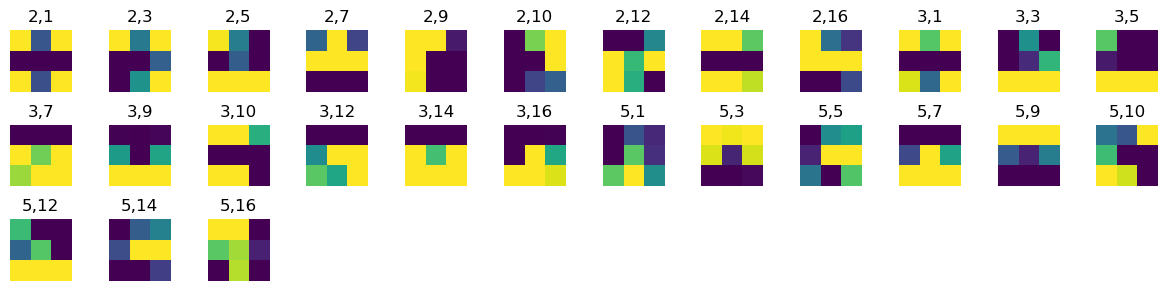

In [112]:
import visualization as v
v.plot_filters_single_channel("visual.png", convs[18], [2,3,5], [1,3,5,7,9,10,12,14,16])

In [155]:
#feature visualization
import data
import visualization as v

model = m.load_torch_hub("resnet18", True)
convs = v.get_convs(model)
convs = v.flatten_list(convs)

img = cv2.imread("cat106.jpg")
transformation = data.compose_transform(3, (224,224))
transformed_img = torch.unsqueeze(transformation(img), 0)

Using cache found in C:\Users\netis/.cache\torch\hub\pytorch_vision_v0.10.0


In [156]:
img.shape

(224, 224, 3)

In [139]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
transformed_img = transformed_img.to(device)

In [140]:
outputs = []
image = transformed_img
for layer in convs:
    print(layer)
    image = layer(image)
    outputs.append(image)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

In [145]:
outputs[0][0].shape

torch.Size([64, 112, 112])

In [146]:
def convert_3d_to_2d(tensor):
    assert len(tensor.shape) == 3
    gray_scale = torch.mean(tensor, 0)
    return gray_scale

In [153]:
feature_map = convert_3d_to_2d(outputs[0][0]).cpu().detach().numpy()

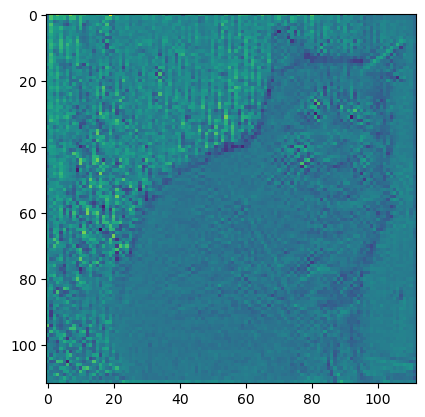

In [154]:
fig = plt.figure()
plt.imshow(feature_map)
plt.show()

In [161]:
my_model = model.load_state_dict(torch.load("resnet18_best.pt"))

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "conv1.0.weight", "conv1.1.weight", "fc.0.weight", "fc.0.bias". 

In [163]:
my_model = m.load_torch_hub("resnet18")
my_model = m.fit_model_structure(my_model, 6, 1)
my_model = my_model.load_state_dict(torch.load("resnet18_best.pt"))

Using cache found in C:\Users\netis/.cache\torch\hub\pytorch_vision_v0.10.0


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv1.0.weight: copying a param with shape torch.Size([64, 12, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 6, 1, 1]).

In [169]:
for val in torch.load("resnet18_best.pt").values():
    print(val.shape)

torch.Size([64, 12, 1, 1])
torch.Size([64, 64, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([

In [13]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import torch
import torch.nn as nn
import model as m
import visualization as v
import data as d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
model = m.load_torch_hub("resnet18", False)
model = m.fit_model_structure(model, 6, 1)

Using cache found in C:\Users\netis/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\netis\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\netis\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
dic = torch.load("model.pt")

In [9]:
model_loaded = model.load_state_dict(dic)

In [34]:
convs = v.get_convs(model)
convs = v.flatten_list(convs)
convs2 = [model.conv1[0]] + convs

In [14]:
X, y = d.dir_to_img_tensor("data")

In [18]:
transform = d.compose_transform(X.shape[-1],img_size=(X.shape[1],X.shape[2]))
dataset = d.MapDataset(X,y,transform)
img_shape = dataset[0][0].shape

In [38]:
convs2[:8]

[Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2), bias=False),
 Conv2d(64, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)]

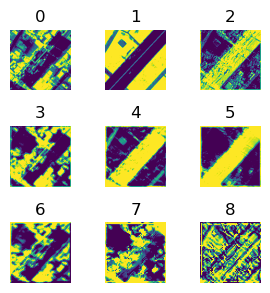

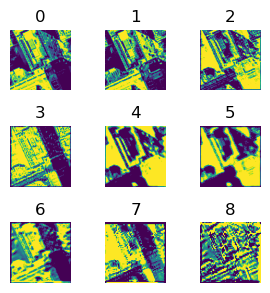

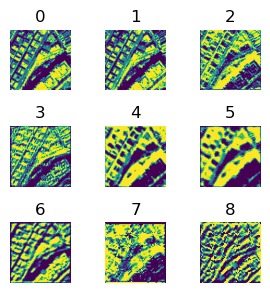

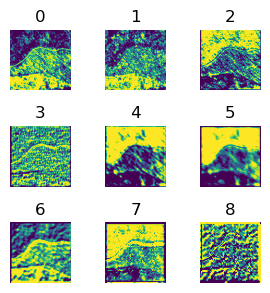

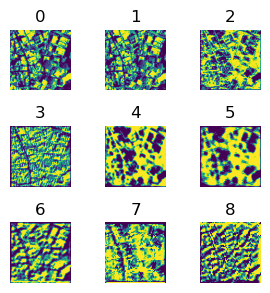

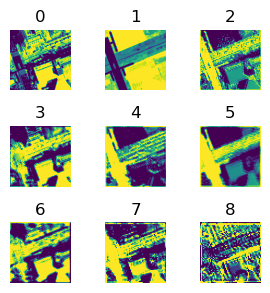

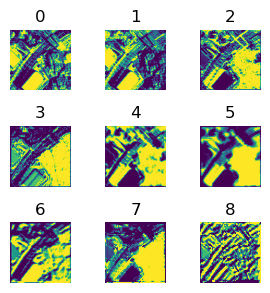

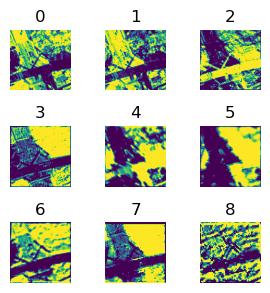

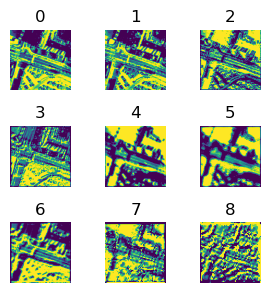

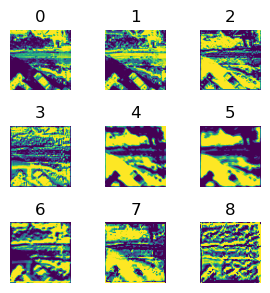

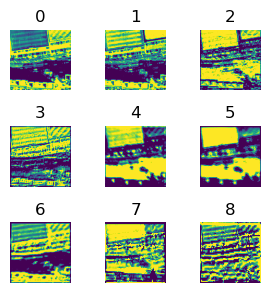

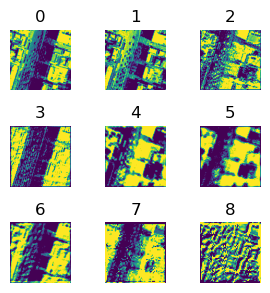

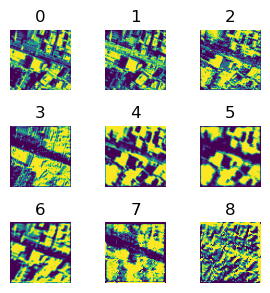

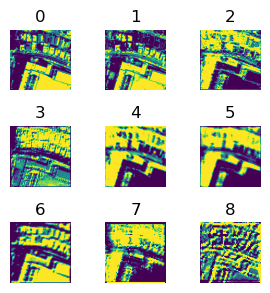

In [39]:
for i in range(X.shape[0]):
    v.plot_features(f"feature2/feature{i}.png", X[i], convs2[:8])